<a href="https://colab.research.google.com/github/shreyabhadwal/Crescere-Stock-Price-Prediction-Web-App-LSTM/blob/main/Stock_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 7.4 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

sns.set_theme(style = "darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [3]:
msft = yf.Ticker("MSFT")
msft = msft.history(period = "max")

print(msft.tail(5))

                  Open        High         Low       Close    Volume  \
Date                                                                   
2022-06-17  244.699997  250.500000  244.029999  247.649994  42800400   
2022-06-21  250.259995  254.750000  249.509995  253.740005  29928300   
2022-06-22  251.889999  257.170013  250.369995  253.130005  25939900   
2022-06-23  255.570007  259.369995  253.630005  258.859985  25861400   
2022-06-24  261.809998  267.980011  261.720001  267.700012  33900700   

            Dividends  Stock Splits  
Date                                 
2022-06-17        0.0           0.0  
2022-06-21        0.0           0.0  
2022-06-22        0.0           0.0  
2022-06-23        0.0           0.0  
2022-06-24        0.0           0.0  


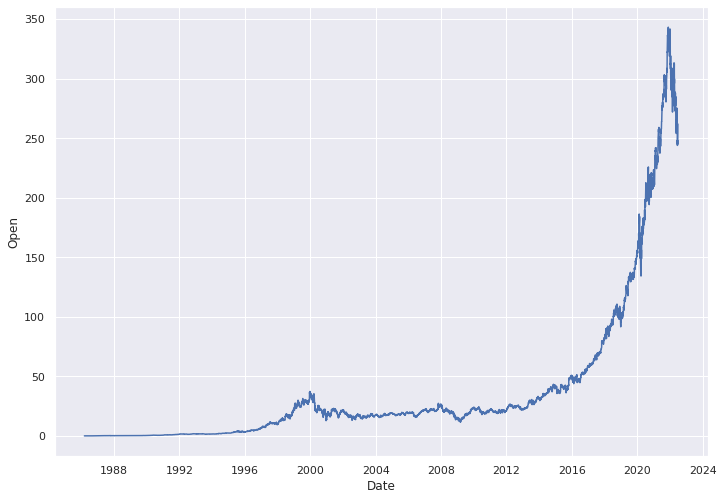

In [4]:
sns.lineplot(x= "Date", y= "Open", data = msft)

msft = msft[['Close']]

In [5]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

In [6]:
def windowed_df(dataframe, first_date_str, last_date_str, n=15):
    
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)

    target_date = first_date
    
    dates = []
    X, Y = [], []
    last_time = False
    
    while True:
        msft_sub = msft.loc[:target_date].tail(n+1)
        
        if len(msft_sub) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return
        
        values = msft_sub['Close'].to_numpy()
        x, y = values[:-1], values[-1]  #x is numpy array of previous 15 day stock price
                                        #y is value of that days stock price
        dates.append(target_date)
        X.append(x)
        Y.append(y)
        
        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]

        #Closing prices of the week (Target Date as start date)
        
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
        
        if last_time:
            break
        
        target_date = next_date
        
        if target_date == last_date:
            last_time = True
        
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
        
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]
        
    ret_df['Target'] = Y

    return(ret_df)
    
windowed_df = windowed_df(msft,'2021-03-25', '2022-03-23', n= 15)
windowed_df

,Target Date,Target-15,Target-14,Target-13,Target-12,Target-11,Target-10,Target-9,Target-8,Target-7,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2021-03-25,224.375504,229.194946,225.028671,231.352295,230.006454,234.667526,233.301849,232.371582,235.241486,234.578430,228.324097,227.957932,233.539368,235.112854,233.014862,229.927277
1,2021-03-26,229.194946,225.028671,231.352295,230.006454,234.667526,233.301849,232.371582,235.241486,234.578430,228.324097,227.957932,233.539368,235.112854,233.014862,229.927277,234.024246
2,2021-03-29,225.028671,231.352295,230.006454,234.667526,233.301849,232.371582,235.241486,234.578430,228.324097,227.957932,233.539368,235.112854,233.014862,229.927277,234.024246,232.797165
3,2021-03-30,231.352295,230.006454,234.667526,233.301849,232.371582,235.241486,234.578430,228.324097,227.957932,233.539368,235.112854,233.014862,229.927277,234.024246,232.797165,229.442337
4,2021-03-31,230.006454,234.667526,233.301849,232.371582,235.241486,234.578430,228.324097,227.957932,233.539368,235.112854,233.014862,229.927277,234.024246,232.797165,229.442337,233.321640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2022-03-17,293.905457,296.619141,298.095703,294.264648,299.492462,295.232391,289.186432,278.261902,275.209015,287.829620,284.926361,279.419220,275.797638,286.482758,293.705933,294.533997
248,2022-03-18,296.619141,298.095703,294.264648,299.492462,295.232391,289.186432,278.261902,275.209015,287.829620,284.926361,279.419220,275.797638,286.482758,293.705933,294.533997,299.731873
249,2022-03-21,298.095703,294.264648,299.492462,295.232391,289.186432,278.261902,275.209015,287.829620,284.926361,279.419220,275.797638,286.482758,293.705933,294.533997,299.731873,298.464844
250,2022-03-22,294.264648,299.492462,295.232391,289.186432,278.261902,275.209015,287.829620,284.926361,279.419220,275.797638,286.482758,293.705933,294.533997,299.731873,298.464844,303.353455


In [7]:
def windowed_df_to_date_X_y(windowed_dataframe):
    
  df_as_np = windowed_dataframe.to_numpy()
  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1)) 
  #Reshape to put it in model

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)
dates.shape, X.shape, y.shape

((252,), (252, 15, 1), (252,))

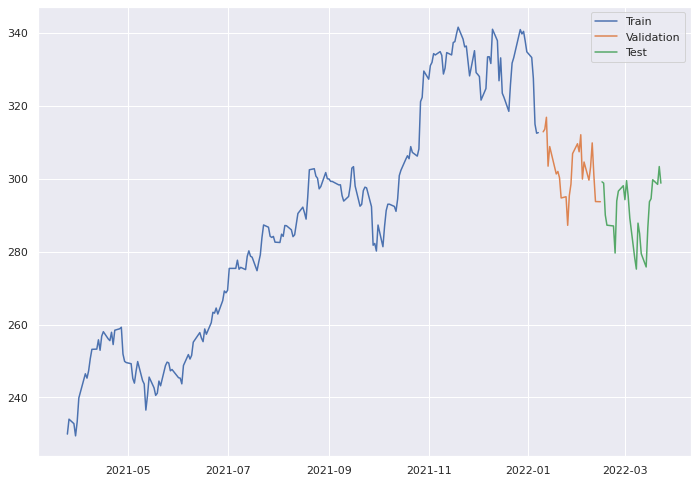

In [8]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
plt.legend(['Train', 'Validation', 'Test'])

In [9]:
X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)
X_val = tf.convert_to_tensor(X_val)

y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)
y_val = tf.convert_to_tensor(y_val)

In [10]:
model = Sequential([layers.Input((15, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 4s 228ms/step - loss: 83363.8906 - mean_absolute_error: 286.9425 - val_loss: 91307.7266 - val_mean_absolute_error: 302.0848
Epoch 2/100
7/7 [==============================] - 0s 30ms/step - loss: 82997.6719 - mean_absolute_error: 286.3044 - val_loss: 90949.7969 - val_mean_absolute_error: 301.4918
Epoch 3/100
7/7 [==============================] - 0s 28ms/step - loss: 82650.3828 - mean_absolute_error: 285.6963 - val_loss: 90545.9688 - val_mean_absolute_error: 300.8213
Epoch 4/100
7/7 [==============================] - 0s 27ms/step - loss: 82219.1875 - mean_absolute_error: 284.9420 - val_loss: 89996.0078 - val_mean_absolute_error: 299.9058
Epoch 5/100
7/7 [==============================] - 0s 27ms/step - loss: 81630.6797 - mean_absolute_error: 283.9069 - val_loss: 89275.3672 - val_mean_absolute_error: 298.7019
Epoch 6/100
7/7 [==============================] - 0s 41ms/step - loss: 80881.3359 - mean_absolute_error: 282.5821 - val_loss: 88

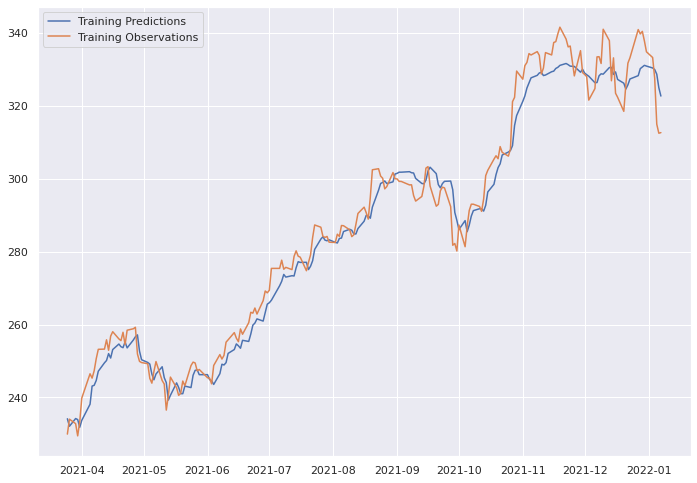

In [11]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

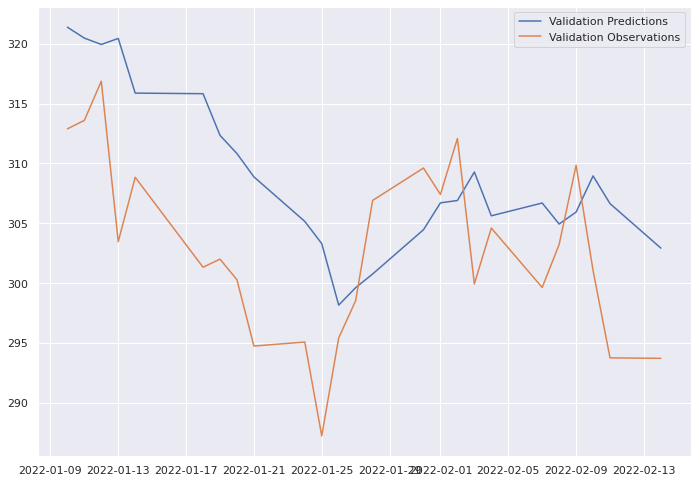

In [12]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

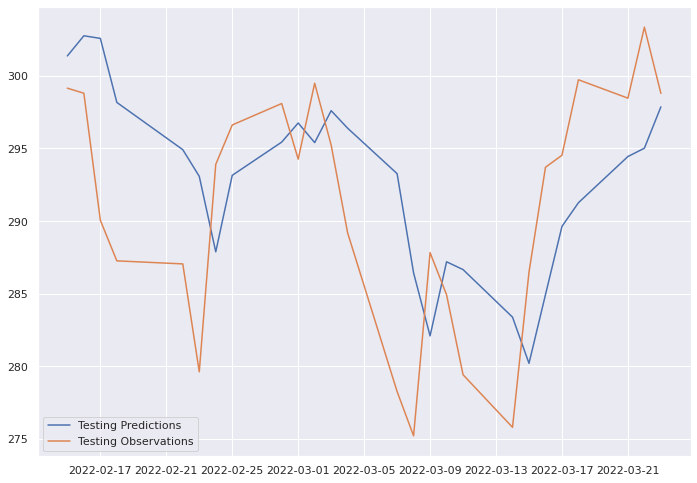

In [13]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

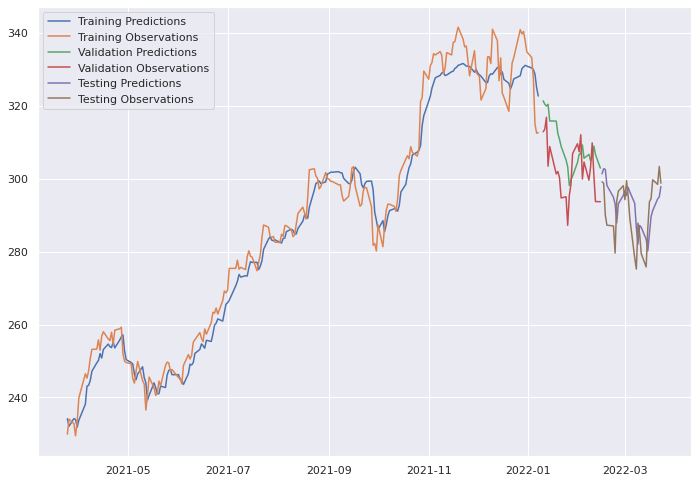

In [14]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [15]:
model.save('/content/drive/MyDrive/Stock_Predict/my_model') 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Stock_Predict/my_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Stock_Predict/my_model/assets


In [16]:
close_data = msft['Close'].values
close_data = close_data.reshape((-1))
close_data

array([6.11093603e-02, 6.32916987e-02, 6.43835068e-02, ...,
       2.53130005e+02, 2.58859985e+02, 2.67700012e+02])

In [17]:
look_back = 15

def predict(num_prediction, model):

    prediction_list = close_data[-look_back:]

    for _ in range(num_prediction):
      x = prediction_list[-look_back:]
      x = x.reshape((1, look_back, 1))
      out = model.predict(x)[0][0]
      prediction_list = np.append(prediction_list, out)
      
    prediction_list = prediction_list[look_back-1:]

    return prediction_list


In [18]:
def predict_dates(num_prediction):

    msft1 = msft.reset_index(level=0, inplace=True)
    last_date = msft['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()

    return prediction_dates

In [19]:
num_prediction = 30
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

In [20]:
forecast_dates

[Timestamp('2022-06-24 00:00:00', freq='D'),
 Timestamp('2022-06-25 00:00:00', freq='D'),
 Timestamp('2022-06-26 00:00:00', freq='D'),
 Timestamp('2022-06-27 00:00:00', freq='D'),
 Timestamp('2022-06-28 00:00:00', freq='D'),
 Timestamp('2022-06-29 00:00:00', freq='D'),
 Timestamp('2022-06-30 00:00:00', freq='D'),
 Timestamp('2022-07-01 00:00:00', freq='D'),
 Timestamp('2022-07-02 00:00:00', freq='D'),
 Timestamp('2022-07-03 00:00:00', freq='D'),
 Timestamp('2022-07-04 00:00:00', freq='D'),
 Timestamp('2022-07-05 00:00:00', freq='D'),
 Timestamp('2022-07-06 00:00:00', freq='D'),
 Timestamp('2022-07-07 00:00:00', freq='D'),
 Timestamp('2022-07-08 00:00:00', freq='D'),
 Timestamp('2022-07-09 00:00:00', freq='D'),
 Timestamp('2022-07-10 00:00:00', freq='D'),
 Timestamp('2022-07-11 00:00:00', freq='D'),
 Timestamp('2022-07-12 00:00:00', freq='D'),
 Timestamp('2022-07-13 00:00:00', freq='D'),
 Timestamp('2022-07-14 00:00:00', freq='D'),
 Timestamp('2022-07-15 00:00:00', freq='D'),
 Timestamp

In [21]:
forecast

array([267.70001221, 261.99209595, 259.89056396, 258.03833008,
       256.49542236, 255.20896912, 254.17799377, 253.37619019,
       252.71585083, 252.16175842, 251.72183228, 251.3306427 ,
       250.94615173, 250.54469299, 250.07965088, 249.55805969,
       249.02526855, 248.49458313, 247.97587585, 247.47465515,
       246.99365234, 246.53367615, 246.09429932, 245.6746521 ,
       245.27339172, 244.88909912, 244.52056885, 244.16700745,
       243.82798767, 243.5035553 , 243.19389343])

In [22]:
msft1 = msft.reset_index(drop = True)

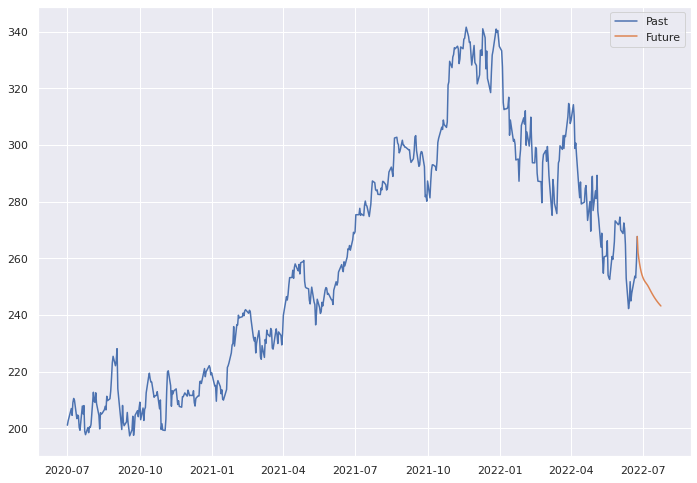

In [23]:
plt.plot(msft1['Date'].tail(500), msft1['Close'].tail(500))
plt.plot(forecast_dates, forecast)

plt.legend(['Past', 'Future'])

In [24]:
model.save('my_model.h5')